In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from packet_utils import count_set_bits, map_nibbles_to_chips, chips_to_int

# Testing IEEE 802.15.4 packet sink block Python translation

In [34]:
print(
    count_set_bits(0b0100_1110_0000_0111_0111_1010_1110_0110, 4)
)  # Counts bits in the lowest 4 bits (0110) → Output: 2

2


In [35]:
# Chip mapping for MSK-based IEEE 802.15.4 demodulation
# Important: sequences are inverted bit-wise. The LSB of each uint32 number
# is the last chip sent on air
CHIP_MAPPING: np.ndarray = np.array(
    [
        0xE077AE6C,  # 0
        0xCE077AE6,  # 1
        0x6CE077AE,  # 2
        0xE6CE077A,  # 3
        0xAE6CE077,  # 4
        0x7AE6CE07,  # 5
        0x77AE6CE0,  # 6
        0x877AE6CE,  # 7
        0x1F885193,  # 8
        0x31F88519,  # 9
        0x931F8851,  # A
        0x1931F885,  # B
        0x51931F88,  # C
        0x851931F8,  # D
        0x8851931F,  # E
        0x78851931,  # F
    ],
    dtype=np.uint32,
)


def decode_chips(chips32: int, threshold: int = 32) -> int:
    """Decodes the received chip sequence by comparing it against a known mapping."""
    best_match = 0xFF
    min_threshold = 33  # Value greater than the maximum possible errors (32 bits)

    for i in range(16):
        # 0x7FFFFFFE masks out the first and last bit, since these depend on previous chip data
        # This is because we are using differential encoding
        masked_diff = (chips32 ^ CHIP_MAPPING[i]) & 0x7FFFFFFE
        diff_bits = count_set_bits(masked_diff, 32)  # Count the number of bits that differ
        print(f"{diff_bits = }")

        if diff_bits < min_threshold:
            best_match = i
            min_threshold = diff_bits

    if min_threshold <= threshold:
        return best_match & 0xF  # Return position in chip mapping

    return 0xFF  # If no valid match was found, return 0xFF to indicate an error.


# Use threshold = 32 to simply find the closest match!
# Use low threshold for preamble detection and length reading
# Use high threshold for payload (we are sure we received a IEEE 802.15.4 packet, but may be interfered during the payload)
test_variable = decode_chips(0b10101110_01101100_11100000_01110111, 32)
print(f"{test_variable = }")

diff_bits = 15
diff_bits = 13
diff_bits = 14
diff_bits = 13
diff_bits = 0
diff_bits = 13
diff_bits = 14
diff_bits = 12
diff_bits = 15
diff_bits = 17
diff_bits = 16
diff_bits = 17
diff_bits = 30
diff_bits = 17
diff_bits = 16
diff_bits = 18
test_variable = 4


In [36]:
# Example usage:
byte_array = [0x00, 0x00, 0x00, 0x00, 0xA7]
print(map_nibbles_to_chips(byte_array, CHIP_MAPPING))

11100000011101111010111001101100_11100000011101111010111001101100_11100000011101111010111001101100_11100000011101111010111001101100_11100000011101111010111001101100_11100000011101111010111001101100_11100000011101111010111001101100_11100000011101111010111001101100_10000111011110101110011011001110_10010011000111111000100001010001


In [37]:
chips = np.array([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1])
result = chips_to_int(chips)
print(bin(result))

test_variable = decode_chips(0b10101110_01101100_11100000_01110111, 32)
print(f"{test_variable = }")

0b10101110011011001110000001110111
diff_bits = 15
diff_bits = 13
diff_bits = 14
diff_bits = 13
diff_bits = 0
diff_bits = 13
diff_bits = 14
diff_bits = 12
diff_bits = 15
diff_bits = 17
diff_bits = 16
diff_bits = 17
diff_bits = 30
diff_bits = 17
diff_bits = 16
diff_bits = 18
test_variable = 4


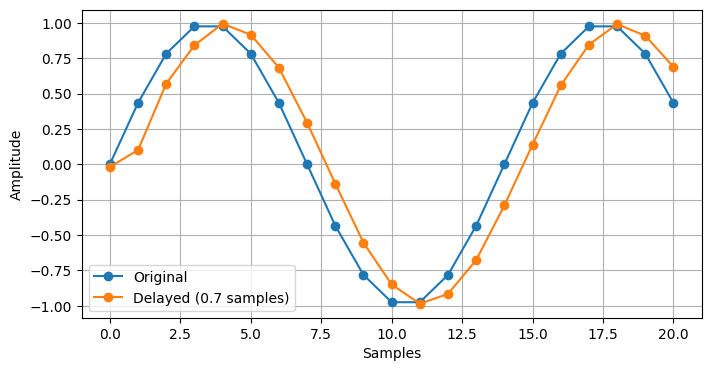

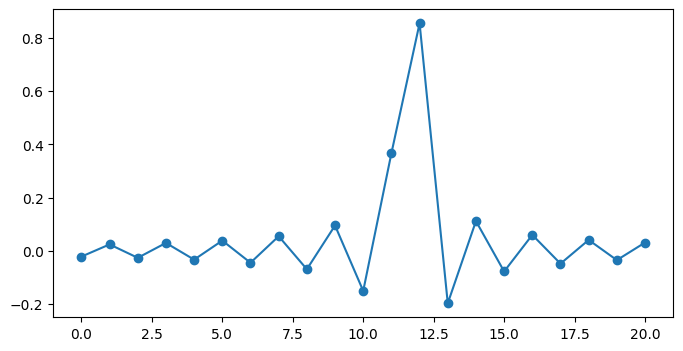

In [38]:
# Applies a delay to the input data by first applying a fractional delay using an FIR filter,
# and then applying an integer delay via sample shifting with zero-padding.
def fractional_delay_fir_filter(data: np.ndarray, delay: float, num_taps: int = 21) -> np.ndarray:
    """
    Applies a delay to the input data by first applying a fractional delay using an FIR filter,
    and then applying an integer delay via sample shifting with zero-padding.
    """
    # Separate delay into its integer and fractional parts
    integer_delay = int(np.floor(delay))
    fractional_delay = delay - integer_delay

    # Build the FIR filter taps for the fractional delay
    n = np.arange(-num_taps // 2, num_taps // 2)  # ...-3,-2,-1,0,1,2,3...
    fir_kernel = np.sinc(n - fractional_delay)  # Shifted sinc function
    # fir_kernel *= np.hamming(len(n))  # Hamming window (avoid spectral leakage)
    fir_kernel /= np.sum(fir_kernel)  # Normalise filter taps, unity gain
    frac_delayed = scipy.signal.convolve(data, fir_kernel, mode="full")  # Apply filter

    # Compensate for the intrinsic delay caused by convolution
    frac_delayed = np.roll(frac_delayed, -num_taps // 2)
    frac_delayed = frac_delayed[: len(data)]

    # Integer delay and pad with zeros
    delayed_output = np.zeros_like(frac_delayed)
    if integer_delay < len(frac_delayed):
        delayed_output[integer_delay:] = frac_delayed[: len(frac_delayed) - integer_delay]

    return delayed_output, fir_kernel


# Generate a test signal
fs = 21  # Sampling rate (arbitrary units)
time = np.arange(0, 1, 1 / fs)
samples = np.sin(2 * np.pi * 1.5 * time)
delay = 0.7
num_taps = 21

delayed_signal, fir_kernel = fractional_delay_fir_filter(samples, delay, num_taps)

# Plot original and delayed signals
plt.figure(figsize=(8, 4))
plt.plot(samples, "o-", label="Original")
plt.plot(delayed_signal, "o-", label=f"Delayed ({delay} samples)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# Plot kernel
plt.figure(figsize=(8, 4))
plt.plot(fir_kernel, "o-", label="Original")
plt.show()

# Matched filtering with rectangular pulses

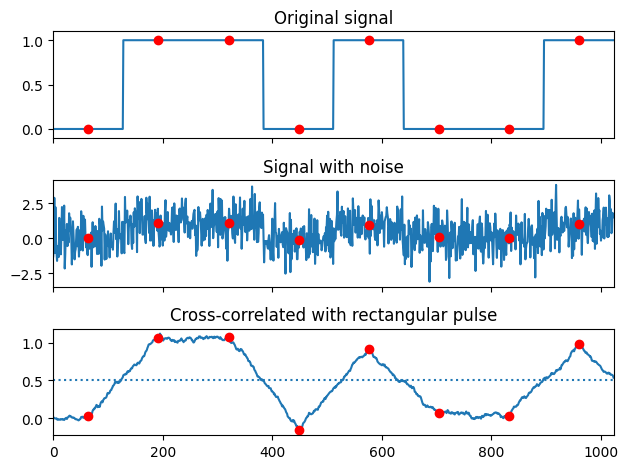

In [39]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

rng = np.random.default_rng()
sig = np.repeat([0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0], 128)
sig_noise = sig + rng.standard_normal(len(sig))
corr = signal.correlate(sig_noise, np.ones(128), mode="same") / 128

clock = np.arange(64, len(sig), 128)
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.plot(clock, sig[clock], "ro")
ax_orig.set_title("Original signal")
ax_noise.plot(sig_noise)
ax_noise.plot(clock, corr[clock], "ro")
ax_noise.set_title("Signal with noise")
ax_corr.plot(corr)
ax_corr.plot(clock, corr[clock], "ro")
ax_corr.axhline(0.5, ls=":")
ax_corr.set_title("Cross-correlated with rectangular pulse")
ax_orig.margins(0, 0.1)
fig.tight_layout()
plt.show()

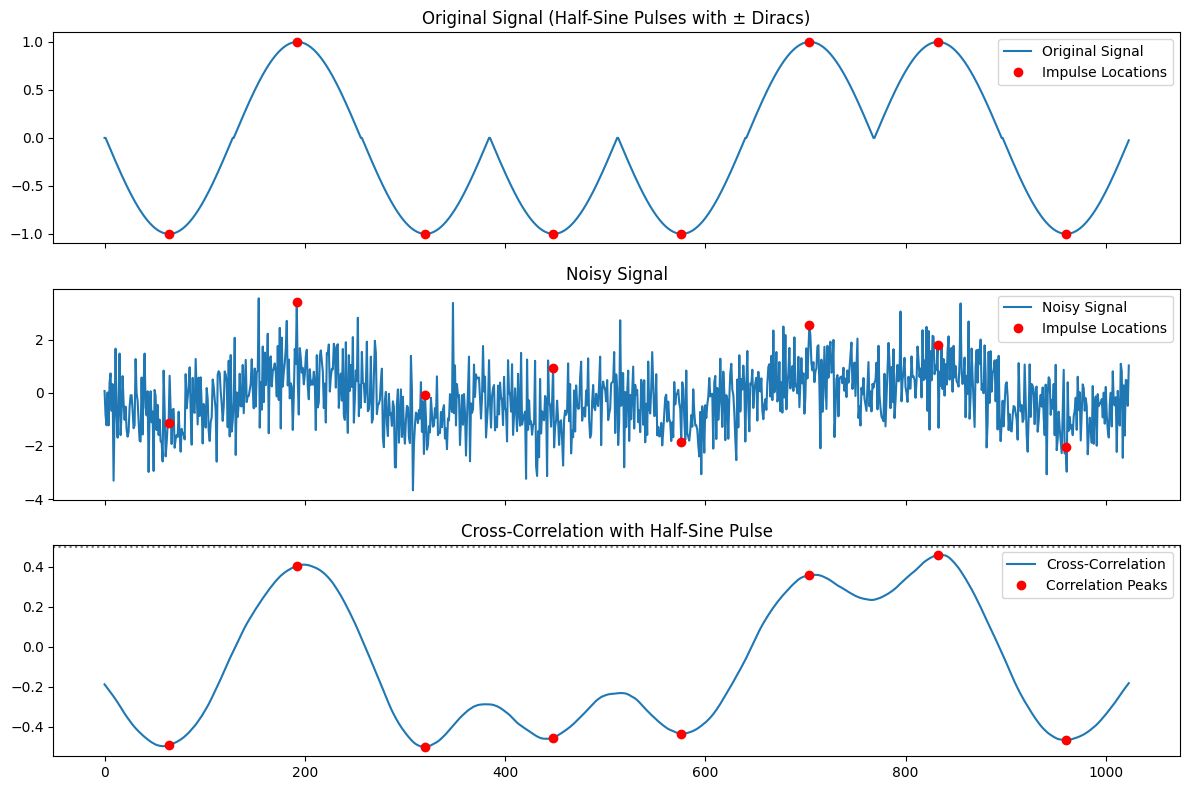

In [40]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Initialize random generator
rng = np.random.default_rng()

# Number of pulses (impulses) to generate
num_pulses = 8

# Generate a random binary sequence with values -1 and +1 for the Dirac impulses
binary_diracs = rng.choice([-1, 1], size=num_pulses)

# Create a signal array long enough to place each impulse at the center of a 128-sample block
signal_length = num_pulses * 128
dirac_signal = np.zeros(signal_length)

# Place each impulse at the center (index 64 of each block)
clock_indices = np.arange(64, signal_length, 128)
dirac_signal[clock_indices] = binary_diracs

# Create a half-sine pulse of length 128
pulse_len = 128
t = np.linspace(0, np.pi, pulse_len)
half_sine_pulse = np.sin(t)

# Convolve the Dirac signal with the half-sine pulse so that:
# +1 Diracs produce positive half-sine pulses and -1 Diracs produce negative half-sine pulses.
orig_signal = np.convolve(dirac_signal, half_sine_pulse, mode="same")

# Add Gaussian noise to the convolved signal
noisy_signal = orig_signal + rng.standard_normal(len(orig_signal))

# Compute convolution (symmetrical kernel) of the noisy signal with the half-sine pulse
corr = signal.convolve(noisy_signal, half_sine_pulse, mode="same") / pulse_len

# Plotting the signals
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True, figsize=(12, 8))

# Original convolved signal
ax_orig.plot(orig_signal, label="Original Signal")
ax_orig.plot(clock_indices, orig_signal[clock_indices], "ro", label="Impulse Locations")
ax_orig.set_title("Original Signal (Half-Sine Pulses with ± Diracs)")
ax_orig.legend()

# Noisy signal
ax_noise.plot(noisy_signal, label="Noisy Signal")
ax_noise.plot(clock_indices, noisy_signal[clock_indices], "ro", label="Impulse Locations")
ax_noise.set_title("Noisy Signal")
ax_noise.legend()

# Cross-correlation with half-sine pulse
ax_corr.plot(corr, label="Cross-Correlation")
ax_corr.plot(clock_indices, corr[clock_indices], "ro", label="Correlation Peaks")
ax_corr.axhline(0.5, ls=":", color="gray")
ax_corr.set_title("Cross-Correlation with Half-Sine Pulse")
ax_corr.legend()

fig.tight_layout()
plt.show()